In [1]:
import os
import subprocess
import sys
import numpy as np
import itertools
import json
from tqdm import tqdm
from IPython.display import display, HTML
import time
import copy
from collections import namedtuple
top_level_dir = '/'.join( os.getcwd().split( '/' )[ :-2 ] )
if top_level_dir not in sys.path:
    sys.path.append( top_level_dir )
%load_ext autoreload
%autoreload 2
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from GenModels.GM.Distributions import Categorical, Dirichlet, TensorTransition, TensorTransitionDirichletPrior
from GenModels.research.PedigreeLoader import load
from GenModels.research.PedigreeWrappers import PedigreeHMMFilter, PedigreeHMMFilterSexMatters, Pedigree, PedigreeSexMatters
from GenModels.research.Models import *

In [3]:
graphs = load()

Graph 4671AT.json is incorrect. 10
Graph 371KD.json is incorrect. 6
Graph 6030CH.json is incorrect. 25
Graph 3743MH.json is incorrect. -1
Graph 5470NG.json is incorrect. -1
Graph 928DW.json is incorrect. -5
Graph 6210HG.json is incorrect. 21
Graph 2049EE.json is incorrect. -1
Graph 1044IO.json is incorrect. -1
Graph 773SM.json is incorrect. 30
Graph 5833TK.json is incorrect. 2
Graph 5738AT.json is incorrect. Can't have an edge with no children!!!!
Graph 3427NF.json is incorrect. -1
Graph 4956RL.json is incorrect. 3
Graph 5022KK.json is incorrect. 31
Graph 5101LV.json is incorrect. 3
Graph 3420MZ.json is incorrect. 2
Graph 3515JA.json is incorrect. 2
Graph 5865MH.json is incorrect. This graph is disjoint!!!
Graph 3919MR.json is incorrect. 1
Graph 473DM.json is incorrect. 30
Graph NEI_INVPK971KPR.json is incorrect. Can't have an edge with no children!!!!
Graph 4737AL.json is incorrect. 2
Graph 5697MS.json is incorrect. 3
Graph 6199RS.json is incorrect. 14
Graph 4835MM.json is incorrect. 

In [4]:
len( graphs )

430

In [5]:
ad_graphs = [ ( graph, fbs ) for graph, fbs in graphs if graph.inheritancePattern == 'AD' ]
ar_graphs = [ ( graph, fbs ) for graph, fbs in graphs if graph.inheritancePattern == 'AR' ]
xl_graphs = [ ( graph, fbs ) for graph, fbs in graphs if graph.inheritancePattern == 'XL' ]
print( 'Number of graphs for AD: %d AR: %d XL: %d'%( len( ad_graphs ), len( ar_graphs ), len( xl_graphs )) )

Number of graphs for AD: 132 AR: 197 XL: 98


# Estimating E[ P( Y ) ] using Mendellian priors is biased towards autosomal recessive

In [6]:
def evaluationGraphs( graph_and_fbs, set_latent_states=True ):
    
    graph, fbs = graph_and_fbs

    graph_sex_matters = graph if isinstance( graph, PedigreeSexMatters ) else PedigreeSexMatters.fromPedigree( graph )
    graph_sex_doesnt_matters = graph if isinstance( graph, Pedigree ) else Pedigree.fromPedigreeSexMatters( graph )
    
    ad_graph = copy.deepcopy( graph_sex_doesnt_matters )
    ar_graph = copy.deepcopy( graph_sex_doesnt_matters )
    xl_graph = copy.deepcopy( graph_sex_matters )

    if( set_latent_states ):
        ad_graph.useDiagnosisImplication( 'AD' )
        ar_graph.useDiagnosisImplication( 'AR' )
        xl_graph.useDiagnosisImplication( 'XL' )

    return ( ad_graph, fbs ), ( ar_graph, fbs ), ( xl_graph, fbs )

def onlineMeanUpdate( mean, val, N ):
    return mean + ( val - mean ) / N

def normalizedScores( ad_score, ar_score, xl_score ):
    normalizer = np.logaddexp.reduce( [ ad_score, ar_score, xl_score ] )
    probs = np.array( [ np.exp( ad_score - normalizer ), np.exp( ar_score - normalizer ), np.exp( xl_score - normalizer ) ] )
    return probs

def distributionComparison( graph, samples=400, strength=4, set_latent_states=True ):

    # Fill in assumptions that we can make about each graph
    ad_graph, ar_graph, xl_graph = evaluationGraphs( graph, set_latent_states=set_latent_states )
    
    # Make the models
    ad_eval = AutosomalDominant( [ ad_graph ], prior_strength=strength, method='Gibbs' )
    ar_eval = AutosomalRecessive( [ ar_graph ], prior_strength=strength, method='Gibbs' )
    xl_eval = XLinkedRecessive( [ xl_graph ], prior_strength=strength, method='Gibbs' )

    ad_score, ar_score, xl_score = 0.0, 0.0, 0.0
    
    for i in range( samples ):
        
        # Sample Θ
        ad_eval.sampleParams()
        ar_eval.sampleParams()
        xl_eval.sampleParams()
        
        # Update the scores
        ad_score = onlineMeanUpdate( ad_score, ad_eval.marginal(), i+1 )
        ar_score = onlineMeanUpdate( ar_score, ar_eval.marginal(), i+1 )
        xl_score = onlineMeanUpdate( xl_score, xl_eval.marginal(), i+1 )     
            
    probs = normalizedScores( ad_score, ar_score, xl_score )
    
    ad_eval.msg.cleanup()
    ar_eval.msg.cleanup()
    xl_eval.msg.cleanup()
    
    # Sort the scores and return the corresponding inheritance pattern
    ad_comp = ( ad_score, 'AD' )
    ar_comp = ( ar_score, 'AR' )
    xl_comp = ( xl_score, 'XL' )
    
    possibilities = [ ad_comp, ar_comp, xl_comp ]
    return sorted( possibilities, key=lambda x: x[ 0 ] )[ -1 ][ 1 ], probs

In [7]:
def classAccuracy( label, predicted, true ):
    predicted_label = predicted[ true == label ]
    return ( predicted_label == label ).sum() / predicted_label.shape[ 0 ]

In [32]:
def fullPredictions( ad_graphs, ar_graphs, xl_graphs, N=100, strength=4, set_latent_states=True ):
    n_graphs = len( ad_graphs ) + len( ar_graphs ) + len( xl_graphs )
    results = []
    with tqdm( total=n_graphs ) as pbar:
        for graph in ad_graphs:
            ip, probs = distributionComparison( graph, samples=N, set_latent_states=set_latent_states, strength=strength )
            results.append( ( graph, ip, 'AD' ) )
            pbar.update( 1 )
#             print( 'Study ID', graph[0].studyID, 'Prediction:', ip, 'True: AD', 'probs', probs )

        for graph in ar_graphs:
            ip, probs = distributionComparison( graph, samples=N, set_latent_states=set_latent_states, strength=strength ) 
            results.append( ( graph, ip, 'AR' ) )
            pbar.update( 1 )
#             print( 'Study ID', graph[0].studyID, 'Prediction:', ip, 'True: AR', 'probs', probs )

        for graph in xl_graphs:
            ip, probs = distributionComparison( graph, samples=N, set_latent_states=set_latent_states, strength=strength ) 
            results.append( ( graph, ip, 'XL' ) )
            pbar.update( 1 )
#             print( 'Study ID', graph[0].studyID, 'Prediction:', ip, 'True: XL', 'probs', probs )
            
    _, predicted, true = list( zip( *results ) )
    predicted = np.array( predicted )
    true = np.array( true )
    
    labels = [ 'AD', 'AR', 'XL' ]
    mat = confusion_matrix( true, predicted, labels=labels )
    plt.imshow( mat )
    plt.colorbar()
    plt.xticks( [ 0, 1, 2 ], labels )
    plt.yticks( [ 0, 1, 2 ], labels )
    plt.show()
    
    print( 'AD Accuracy:', classAccuracy( 'AD', predicted, true ) )
    print( 'AR Accuracy:', classAccuracy( 'AR', predicted, true ) )
    print( 'XL Accuracy:', classAccuracy( 'XL', predicted, true ) )

In [33]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [34]:
N = 100
# Randomly sample 10 graphs from each class to do inference on
K = 10
ind_ad = np.random.choice( len( ad_graphs ), size=K, replace=False )
ind_ar = np.random.choice( len( ar_graphs ), size=K, replace=False )
ind_xl = np.random.choice( len( xl_graphs ), size=K, replace=False )

In [35]:
ad_test = [ ad_graphs[ i ] for i in ind_ad ]
ar_test = [ ar_graphs[ i ] for i in ind_ar ]
xl_test = [ xl_graphs[ i ] for i in ind_xl ]

100%|██████████| 30/30 [07:13<00:00, 13.56s/it]


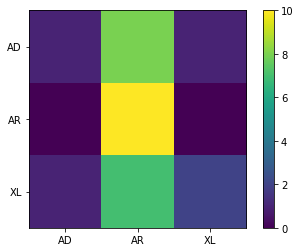

AD Accuracy: 0.1
AR Accuracy: 1.0
XL Accuracy: 0.2


In [37]:
fullPredictions( ad_test, ar_test, xl_test, N=100, strength=4, set_latent_states=True )

# What if we didn't have rare diseases?

In [13]:
ad_true = AutosomalDominant(prior_strength=30, method='Gibbs' )
ar_true = AutosomalRecessive( prior_strength=30, method='Gibbs' )
xl_true = XLinkedRecessive( prior_strength=30, method='Gibbs' )

In [14]:
ad_test_copy = copy.deepcopy( ad_test )
ar_test_copy = copy.deepcopy( ar_test )
xl_test_copy = copy.deepcopy( xl_test )

In [15]:
def setCommonStates( graphs, true_model ):
    for i, ( graph, fbs ) in enumerate( graphs ):
        true_model.setGraphs( [ ( graph, fbs ) ] )
        _, data = true_model.sampleStates( measurements=1000 )
        graph.setNodeData( data.keys(), data.values() )

In [16]:
setCommonStates( ad_test_copy, ad_true )
setCommonStates( ar_test_copy, ar_true )
setCommonStates( xl_test_copy, xl_true )

100%|██████████| 30/30 [08:01<00:00, 13.06s/it]


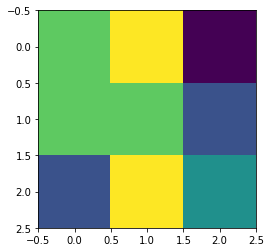

0.4
0.4
0.3


In [17]:
fullPredictions( ad_test_copy, ar_test_copy, xl_test_copy, N=100, strength=4, set_latent_states=False )

100%|██████████| 30/30 [08:01<00:00, 13.04s/it]


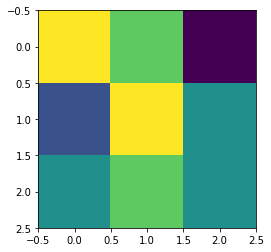

0.5
0.5
0.3


In [18]:
fullPredictions( ad_test_copy, ar_test_copy, xl_test_copy, N=100, strength=30, set_latent_states=False )

100%|██████████| 30/30 [08:01<00:00, 13.04s/it]


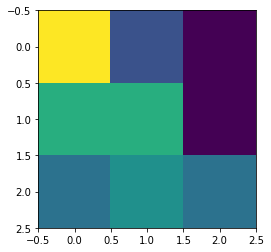

0.8
0.5
0.3


In [19]:
fullPredictions( ad_test_copy, ar_test_copy, xl_test_copy, N=100, strength=30, set_latent_states=False )

100%|██████████| 30/30 [08:02<00:00, 13.07s/it]


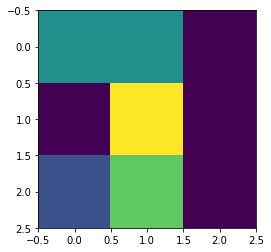

0.4
0.6
0.2


In [20]:
fullPredictions( ad_test_copy, ar_test_copy, xl_test_copy, N=100, strength=30, set_latent_states=False )

100%|██████████| 30/30 [08:02<00:00, 13.05s/it]


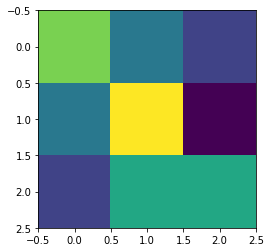

0.5
0.6
0.4


In [21]:
fullPredictions( ad_test_copy, ar_test_copy, xl_test_copy, N=100, strength=30, set_latent_states=False )